In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.stem import WordNetLemmatizer
%matplotlib inline

In [13]:
df = pd.read_csv('data/espn_three_classes.csv')

In [14]:
#check for null values
df.isna().sum()

headlines      2
posted_time    0
tokens         0
labels         0
word_length    0
dtype: int64

In [15]:
df.dropna(inplace=True)

In [16]:
df.nunique()

headlines      36081
posted_time     1880
tokens         36063
labels             3
word_length       20
dtype: int64

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df['labels'].value_counts()

0    25189
1     6069
2     5280
Name: labels, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36538 entries, 0 to 36640
Data columns (total 5 columns):
headlines      36538 non-null object
posted_time    36538 non-null object
tokens         36538 non-null object
labels         36538 non-null int64
word_length    36538 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


In [24]:
stopwords = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

In [30]:
def tfidf_vectorizer(dataframe):
    
    tfidf = TfidfVectorizer(stop_words=stopwords)
    tfidf_sparse_mat = tfidf.fit_transform(dataframe['headlines'])
    
    tfidf_df = pd.DataFrame(tfidf_sparse_mat.toarray())
    tfidf_df.columns = tfidf.get_feature_names()
    
    return tfidf_df

In [48]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [31]:
df_modeling = tfidf_vectorizer(df)

In [32]:
X = df_modeling
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [46]:
mnb_vanilla = MultinomialNB()
mnb_vanilla.fit(X_train, y_train)
mnb_vanilla_cv = cross_val_score(mnb_vanilla, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)


In [45]:
def summary_scores(model, train_set_x, test_set_x, train_set_y, test_set_y, cross_val_var):
    print(f'Training Accuracy: {model.score(train_set_x, train_set_y)}')
    print(f'Cross Validation Accuracy: {np.mean(cross_val_var)}')
    print(f'Testing Accuracy: {model.score(test_set_x, test_set_y)}')
    

In [47]:
summary_scores(mnb_vanilla, X_train, X_test, y_train, y_test, mnb_vanilla_cv)

Training Accuracy: 0.919885830466062
Cross Validation Accuracy: 0.8973646245806955
Testing Accuracy: 0.9064951651158548


In [50]:
print(classification_report(y_test, mnb_vanilla.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      7557
           1       0.89      0.85      0.87      1821
           2       0.94      0.68      0.79      1584

    accuracy                           0.91     10962
   macro avg       0.91      0.83      0.87     10962
weighted avg       0.91      0.91      0.90     10962



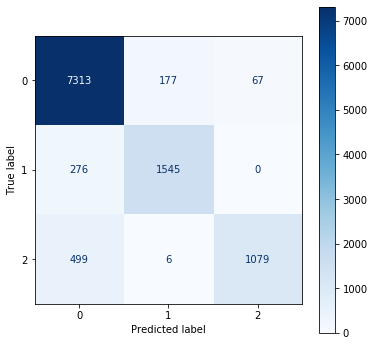

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(mnb_vanilla, X_test, y_test, cmap='Blues', ax=ax)

In [56]:
mnb_vanilla_param = {'alpha':[0, 0.01, 1, 2, 10],
                     'fit_prior':[True, False]}

gs_mnb = GridSearchCV(mnb_vanilla, param_grid=mnb_vanilla_param, cv=5, n_jobs=-1)
gs_mnb.fit(X_train, y_train)
gs_mnb.best_params_

{'alpha': 10, 'fit_prior': False}

In [57]:
gs_mnb_vanilla_cv_mean = cross_val_score(gs_mnb, X_train, y_train,
                                                 cv=5, scoring='accuracy', n_jobs=-1)

In [58]:
summary_scores(gs_mnb, X_train, X_test, y_train, y_test, gs_mnb_vanilla_cv_mean)

Training Accuracy: 0.9183609634031905
Cross Validation Accuracy: 0.9081169688256878
Testing Accuracy: 0.9069512862616311


In [52]:
rf_vanilla = RandomForestClassifier()
rf_vanilla.fit(X_train, y_train)
rf_vanilla_cv = cross_val_score(rf_vanilla, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [53]:
summary_scores(rf_vanilla, X_train, X_test, y_train, y_test, rf_vanilla_cv)

Training Accuracy: 1.0
Cross Validation Accuracy: 0.9765013523975918
Testing Accuracy: 0.9787447546068235


In [54]:
print(classification_report(y_test, rf_vanilla.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7557
           1       0.91      0.99      0.94      1821
           2       0.99      0.99      0.99      1584

    accuracy                           0.98     10962
   macro avg       0.96      0.98      0.97     10962
weighted avg       0.98      0.98      0.98     10962



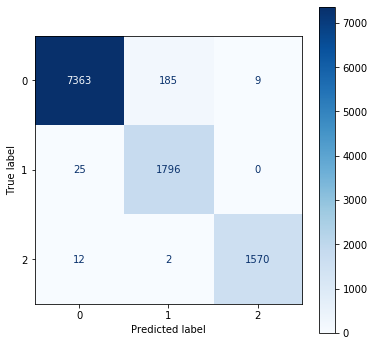

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(rf_vanilla, X_test, y_test, cmap='Blues', ax=ax)